In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os.path as op
import pandas as pd
from mriqc.viz.misc import raters_variability_plot, plot_abide_stripplots, plot_corrmat, plot_histograms

In [ ]:
data_path = '/home/oesteban/Google Drive/mriqc'
x_path = op.join(data_path, 'aMRIQC_abide_20161130.csv')
# y_path = op.join(data_path, 'ABIDE_QC_Marie.csv')
y_path = op.join(data_path, 'ABIDE_QC_all.csv')

In [ ]:
fig = raters_variability_plot(y_path)

In [ ]:
fig = plot_abide_stripplots(x_path, y_path)

In [ ]:
fig = plot_corrmat(x_path)

In [ ]:
fig = plot_histograms(x_path, y_path)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os.path as op
import pandas as pd
import numpy as np
data_path = '/home/oesteban/Google Drive/mriqc'
loso = pd.read_csv(op.join(data_path, 'cv_loso_wtaskid.csv'), index_col=False, na_values='n/a', na_filter=False)
kfold = pd.read_csv(op.join(data_path, 'cv_10fold_wtaskid.csv'), index_col=False, na_values='n/a', na_filter=False)

def gen_newparams(dataframe):
    thisdf = dataframe.copy()
    thisdf['zscored_str'] = ['nzs'] * len(thisdf['zscored'])
    thisdf.loc[thisdf.zscored == 1, 'zscored_str'] = 'zs'
    thisdf['params'] = thisdf['clf'] + '-' + thisdf['zscored_str'] + ' ' + thisdf['params']
    del thisdf['zscored_str']
    return thisdf

In [2]:
loso = gen_newparams(loso)
kfold = gen_newparams(kfold)

In [3]:
loso_models_list = list(set(loso.params.values.ravel().tolist()))
kfold_models_list = list(set(kfold.params.values.ravel().tolist()))

In [4]:
best_param = {}

spstr = ['LoSo', '10-fold']
best_models = {}
for i, split_cv in enumerate([loso, kfold]):
    best_models[spstr[i]] = {}
    splitcols = [col for col in split_cv.columns.ravel() if col.startswith('split0')]
    for clf in ['svc_linear-nzs', 'svc_rbf-nzs', 'rfc-nzs', 'svc_linear-zs', 'svc_rbf-zs', 'rfc-zs']:
        thismodeldf = split_cv.loc[split_cv.params.str.contains(clf)]
        max_auc = thismodeldf.mean_auc.max()
        best = thismodeldf.loc[thismodeldf.mean_auc >= max_auc]
        best_list = best.params.values.ravel().tolist()
        
        if len(best_list) == 1:
            best_models[spstr[i]][clf] = best_list[0]
        else:
            overall_means = [thismodeldf.loc[thismodeldf.params.str.contains(pset), 'mean_auc'].mean()
                             for pset in best_list]
            overall_max = np.max(overall_means)
            if sum([val >= overall_max for val in overall_means]) == 1:
                best_models[spstr[i]][clf] = best_list[np.argmax(overall_means)]
            else:
                best_models[spstr[i]][clf] = best_list[0]    

In [5]:
newdict = {'AUC': [], 'Classifier': [], 'Split scheme': []}

modelnames = {'rfc-nzs': 'RFC-nzs', 'rfc-zs': 'RFC-zs',
              'svc_linear-nzs': 'SVC_lin-nzs', 'svc_linear-zs': 'SVC_lin-zs',
              'svc_rbf-nzs': 'SVC_rbf-nzs', 'svc_rbf-zs': 'SVC_rbf-zs'}

for key, val in list(best_models['LoSo'].items()):
    scores = loso.loc[loso.params.str.contains(val), 'mean_auc'].values.ravel().tolist()
    nscores = len(scores)
   
    newdict['AUC'] += scores
    newdict['Classifier'] += [modelnames[key]] * nscores
    newdict['Split scheme'] += ['LoSo (16 folds)'] * nscores
    
for key, val in list(best_models['10-fold'].items()):
    scores = kfold.loc[kfold.params.str.contains(val), 'mean_auc'].values.ravel().tolist()
    nscores = len(scores)
   
    newdict['AUC'] += scores
    newdict['Classifier'] += [modelnames[key]] * nscores
    newdict['Split scheme'] += ['10-fold'] * nscores

newdf = pd.DataFrame(newdict).sort_values(by=['Split scheme', 'Classifier'])

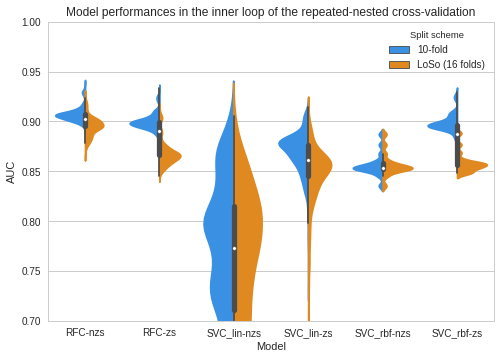

In [9]:
import seaborn as sn
sn.set(style="whitegrid")

ax = sn.violinplot(x='Classifier', y='AUC', hue='Split scheme', data=newdf, split=True, palette=['dodgerblue', 'darkorange'])

ax.set_ylim([0.70, 1.0])
ax.set_ylabel('AUC')
ax.set_xlabel('Model')
ax.set_title('Model performances in the inner loop of the repeated-nested cross-validation')